In [3]:
# !pip3 install nltk
# import nltk
# nltk.download()

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['label', 'message'])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# messages.describe()
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

### EDA & Feature Engineering

In [10]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<AxesSubplot:ylabel='Frequency'>

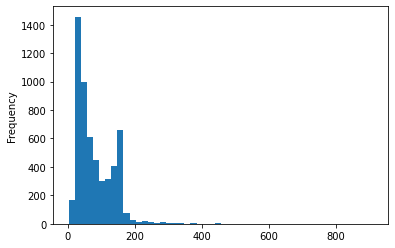

In [12]:
messages['length'].plot(bins=50, kind='hist')

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

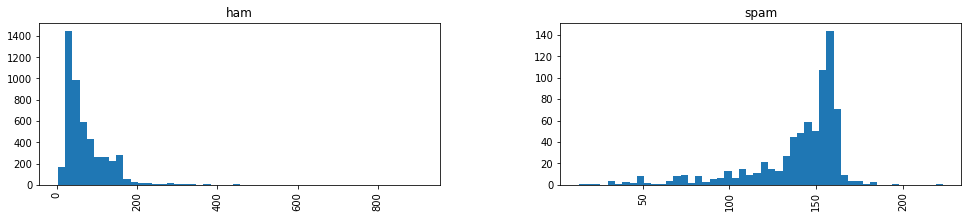

In [16]:
messages.hist(column='length', by='label', bins=50, figsize=(16,3))

## Text Pre-Procesing
- Bag of words: simplest mappling from words to integer

### Vectorization
- Convert message to a vector
1. count how many times a word occur in a message
2. <b>IDF:</b> Frequent tokens get lower weights
3. <b>L2 norm:</b> Normalize the vectors to unit length

In [27]:
import string
from nltk.corpus import stopwords

def textProcess(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    cleanMessage = [w for w in nopunc.split() if w.lower() not in stopwords.words('english')]
    return cleanMessage

messages['message'].head(5).apply(textProcess)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
bowTransformer = CountVectorizer(analyzer=textProcess).fit(messages['message'])

print(len(bowTransformer.vocabulary_))

11425


In [34]:
msgTemp = messages['message'][3]
bowTemp = bowTransformer.transform([msgTemp])
print(bowTemp)
print(bowTransformer.get_feature_names_out()[4073])
bowTemp.shape

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
UIN


(1, 11425)

In [35]:
messagesBOW = bowTransformer.transform(messages['message'])
print('Shape of sparse matrix:', messagesBOW.shape)
print('Amount of non-zero occurances:', messagesBOW.nnz)

Shape of sparse matrix: (5572, 11425)
Amount of non-zero occurances: 50548


In [36]:
sparsity = (100.0 * messagesBOW.nnz / (messagesBOW.shape[0]*messagesBOW.shape[1]))
print('sparcity:', sparsity)

sparcity: 0.07940295412668218


### TF-IDF
- To find how important a word is in a document
- proportinal to number of times word in a document
- offset by the frequency of word in the corpus

* TF(t): (# t appears in document) / (total number of terms in document)
* IDF(t): log_e( #documents / (number of documents containing t) )

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfTransformer = TfidfTransformer().fit(messagesBOW)

In [40]:
print(tfidfTransformer.transform(bowTemp))
print(tfidfTransformer.idf_[bowTransformer.vocabulary_['u']])
print(tfidfTransformer.idf_[bowTransformer.vocabulary_['university']])

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067
3.2800524267409408
8.527076498901426


In [41]:
messagesTFIDF = tfidfTransformer.transform(messagesBOW)
print(messagesTFIDF.shape)

(5572, 11425)


### Training Model

In [42]:
from sklearn.naive_bayes import MultinomialNB
spamDetectModel = MultinomialNB().fit(messagesTFIDF, messages['label'])

In [43]:
print(spamDetectModel.predict(tfidfTransformer.transform(bowTemp)))

['ham']


### Model Evaluation

In [44]:
allPredictions = spamDetectModel.predict(messagesTFIDF)
print(allPredictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [45]:
from sklearn.metrics import classification_report
print(classification_report(messages['label'], allPredictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



### Data Pipeliine

In [49]:
from sklearn.model_selection import train_test_split
msgTrain, msgTest, labelTrain, labelTest = train_test_split(messages['message'], messages['label'], test_size=0.2)

In [50]:
from sklearn.pipeline import Pipeline

In [51]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=textProcess)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [52]:
pipeline.fit(msgTrain, labelTrain)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function textProcess at 0x13e877790>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [53]:
predictions = pipeline.predict(msgTest)

In [54]:
print(classification_report(predictions, labelTest))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1002
        spam       0.74      1.00      0.85       113

    accuracy                           0.96      1115
   macro avg       0.87      0.98      0.91      1115
weighted avg       0.97      0.96      0.97      1115

